In [1]:
from typing import Callable

import polars as pl
import matplotlib.pyplot as plt
import blitzbeaver as bb
import json

In [2]:
csv_path = "../../aptihramy/data/csv_cleaned"
beaver_folder_path = "../data/beaver_files"
json_folder_path = "../data/json_files"

In [3]:
class MetricsResult:
    def __init__(
        self,
        verifier: dict[str, float],
        memory_distance: dict[str, float],
        start_years: list[int],
        end_years: list[int],
        chain_lengths: list[int],
        avg_records_match: float,
        avg_trackers_match: float,
        histogram_records: list[int],
        histogram_trackers: list[int],
    ) -> None:
        self.verifier = verifier
        self.memory_distance = memory_distance
        self.start_years = start_years
        self.end_years = end_years
        self.chain_lengths = chain_lengths
        self.avg_records_match = avg_records_match
        self.avg_trackers_match = avg_trackers_match
        self.histogram_records = histogram_records
        self.histogram_trackers = histogram_trackers


class StatClass:
    def __init__(
        self,
        name: str,
        x: list[float],
        y: list[float],
        configs: list[bb.TrackingConfig],
    ) -> None:
        self.name = name
        self.x = x
        self.y = y
        self.configs = configs

In [4]:
def load_metrics_results(filename: str) -> list[tuple[bb.TrackingConfig, MetricsResult]]:
    filepath = f"{json_folder_path}/{filename}"
    with open(filepath, "r") as file:
        data = json.load(file)
    results = []
    for raw in data:
        config = bb.deserialize_tracking_config(raw["config"])
        data = raw["data"]
        metrics_result = MetricsResult(
            verifier=data["verifier"],
            memory_distance=data["memory_distance"],
            start_years=data["start_years"],
            end_years=data["end_years"],
            chain_lengths=data["chain_lengths"],
            avg_records_match=data["avg_records_match"],
            avg_trackers_match=data["avg_trackers_match"],
            histogram_records=data["histogram_records"],
            histogram_trackers=data["histogram_trackers"],
        )
        results.append((config, metrics_result))
    
    return results

In [5]:
def histogram_mean(histogram: list[int]) -> float:
    total = 0
    for i, count in enumerate(histogram):
        total += i * count
    return total / sum(histogram)

def histogram_median(histogram: list[int]) -> float:
    n = sum(histogram)
    half = n // 2
    i = 0
    while n > half:
        n -= histogram[i]
        i += 1
    return i - 1

In [253]:
results = []
# results += load_metrics_results("configs_p1.json")
# results += load_metrics_results("configs_p2.json")
# results += load_metrics_results("configs_p3.json")
# results += load_metrics_results("configs_p4.json")
# results += load_metrics_results("configs_p5.json")
results += load_metrics_results("configs_p6.json")

In [254]:
def compute_stat_classes(
    results: list[tuple[bb.TrackingConfig, MetricsResult]],
    groupby: Callable[[bb.TrackingConfig], str],
    max_x: int | None = None,
) -> list[StatClass]:

    groups: dict[str, StatClass] = {}

    for result in results:
        config = result[0]
        metrics = result[1]
        x = histogram_mean(metrics.histogram_records)
        y = histogram_mean(metrics.chain_lengths)

        if max_x is not None and x >= max_x:
            continue

        name = groupby(config)

        if not name in groups:
            groups[name] = StatClass(name, [], [], [])
        group = groups[name]

        group.x.append(x)
        group.y.append(y)
        group.configs.append(config)

    return list(groups.values())

def display_stat_classes(stat_classes: list[StatClass]) -> None:
    plt.figure(figsize=(22, 14))
    for stat_class in stat_classes:
        plt.scatter(stat_class.x, stat_class.y, label=stat_class.name, alpha=1.0, s=50)
    plt.legend()
    plt.plot()

In [255]:
groupby_threshold = lambda c: str(c.tracker.interest_threshold)
groupby_lv_substring = lambda c: str(c.distance_metric.lv_substring_weight if c.distance_metric.lv_substring_weight else "other")
groupby_weights = lambda c: ", ".join(f"{w:.2f}" for w in c.tracker.record_scorer.weights) if c.tracker.record_scorer.weights else "average"
groupby_memory = lambda c: str(c.tracker.memories[0].memory_strategy)
groupby_min_weight_ratio = lambda c: str(c.tracker.record_scorer.min_weight_ratio) if c.tracker.record_scorer.min_weight_ratio else "1.0"
groupby_multiword_threshold = lambda c: str(c.tracker.memories[-1].multiword_threshold_match)

In [256]:
classes = compute_stat_classes(
    results,
    groupby=groupby_weights,
    max_x=1.3,
)

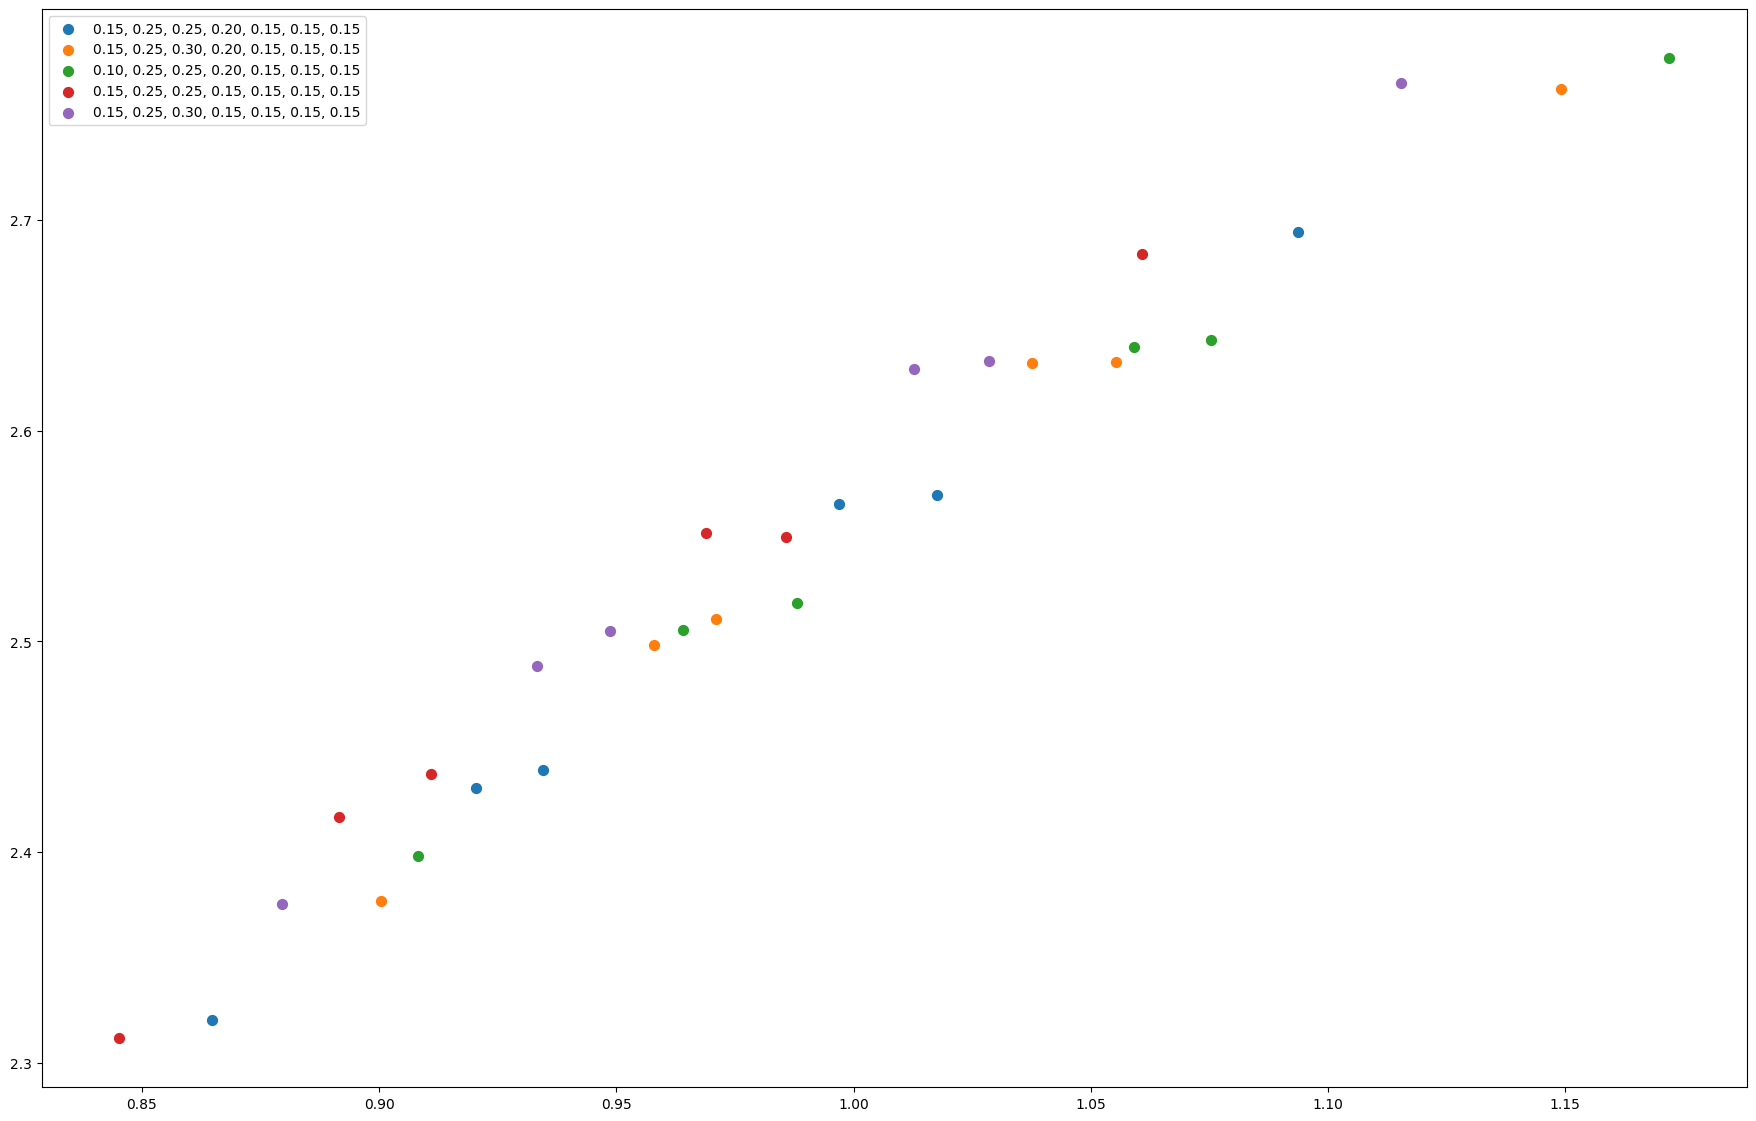

In [257]:
display_stat_classes(classes)

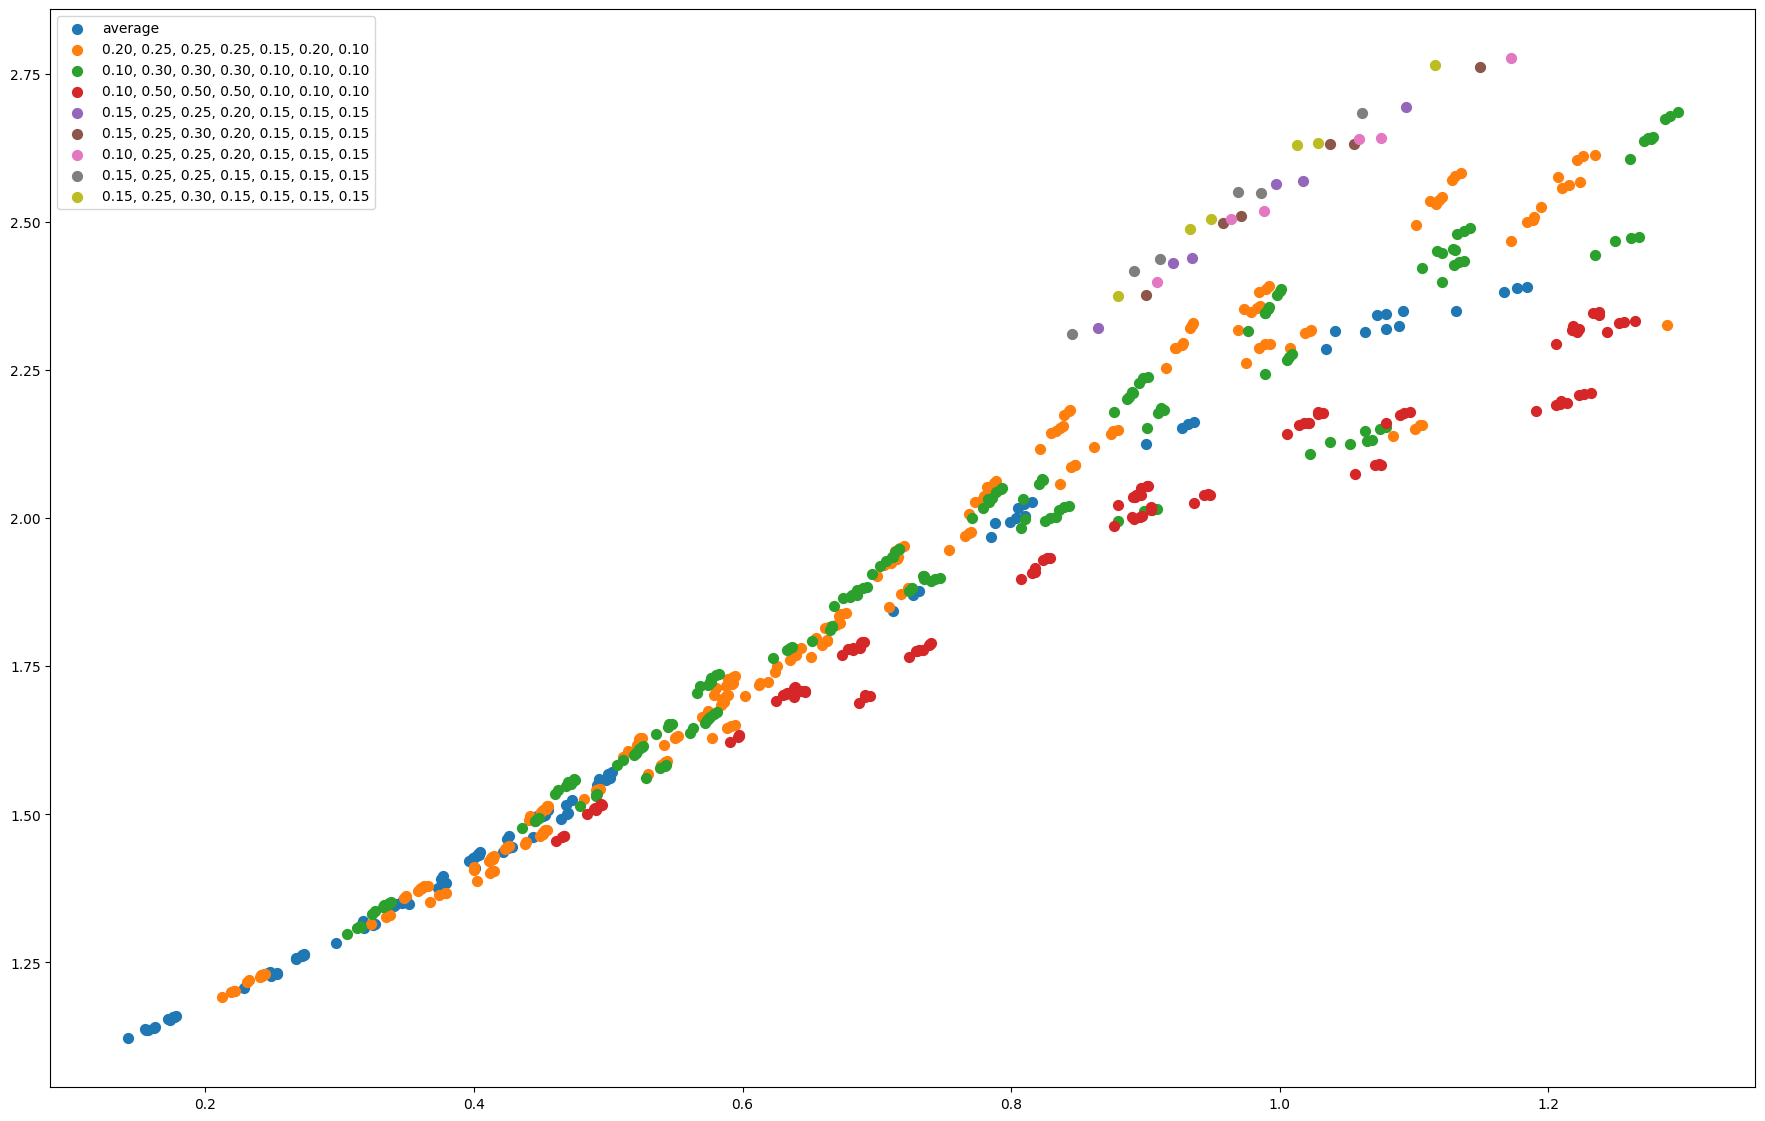

In [252]:
display_stat_classes(classes)

In [104]:
def find_datapoints(
        classes: list[StatClass],
        x_range: tuple[float, float],
        y_range: tuple[float, float],
) -> list[tuple[float, float, bb.TrackingConfig]]:
    configs = []
    for stat_class in classes:
        for x, y, config in zip(stat_class.x, stat_class.y, stat_class.configs):
            if x_range[0] <= x <= x_range[1] and y_range[0] <= y <= y_range[1]:
                configs.append((x, y, config))
    return configs

In [258]:
dps = find_datapoints(
    classes,
    x_range=(0.95, 1.05),
    y_range=(2.35, 10.0),
)

In [259]:
dps

[(0.9969497946031043, 2.565167376049695, <TrackingConfig at 0x7fba3ee6a3d0>),
 (1.01748948417091, 2.569453246528778, <TrackingConfig at 0x7fba3ee6b2d0>),
 (0.9580104789314442, 2.498067551671988, <TrackingConfig at 0x7fba3ee696b0>),
 (1.0376601972794135, 2.6319268220714074, <TrackingConfig at 0x7fba3ee68990>),
 (0.9710476471601112, 2.5105832019815355, <TrackingConfig at 0x7fba3ee69020>),
 (0.9639632991415148, 2.505505617977528, <TrackingConfig at 0x7fba3ee68f30>),
 (0.9880205642879984, 2.518380484499407, <TrackingConfig at 0x7fba3ee6a4c0>),
 (0.9689075836961601, 2.551518965615882, <TrackingConfig at 0x7fba3ee6af10>),
 (0.9857329102403267, 2.549476933630595, <TrackingConfig at 0x7fba3ee6a1f0>),
 (1.0127173886306053, 2.629444018630977, <TrackingConfig at 0x7fba3ee6a100>),
 (1.0285341795193466, 2.6331699828777233, <TrackingConfig at 0x7fba3ee69b60>)]

In [262]:
bb.serialize_tracking_config(dps[-2][2])

{'num_threads': 17,
 'tracker': {'interest_threshold': 0.7900000214576721,
  'limit_no_match_streak': 4,
  'record_scorer': {'record_scorer': 'weighted-average',
   'weights': [0.15000000596046448,
    0.25,
    0.30000001192092896,
    0.15000000596046448,
    0.15000000596046448,
    0.15000000596046448,
    0.15000000596046448],
   'min_weight_ratio': 0.699999988079071},
  'memories': [{'memory_strategy': 'ls-median',
    'multiword_threshold_match': None,
    'multiword_distance_metric': None},
   {'memory_strategy': 'ls-median',
    'multiword_threshold_match': None,
    'multiword_distance_metric': None},
   {'memory_strategy': 'ls-median',
    'multiword_threshold_match': None,
    'multiword_distance_metric': None},
   {'memory_strategy': 'ls-median',
    'multiword_threshold_match': None,
    'multiword_distance_metric': None},
   {'memory_strategy': 'ls-median',
    'multiword_threshold_match': None,
    'multiword_distance_metric': None},
   {'memory_strategy': 'ls-median',
